In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from skimage import transform

import copy

In [5]:
torch.__version__
#torchvision.transforms.__version__

'2.3.0+cu121'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [ ]:
# desired size of the output image
imsize = (800,500)# use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("DRR.png")
content_img = image_loader("LP1027.png")


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [ ]:
content_img.shape

torch.Size([1, 3, 800, 500])

In [ ]:
style_img.shape

torch.Size([1, 3, 800, 500])

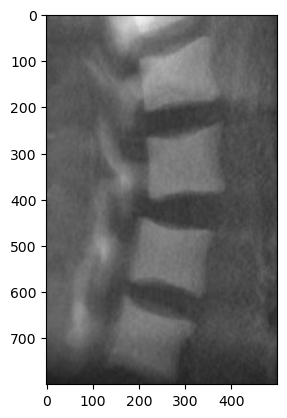

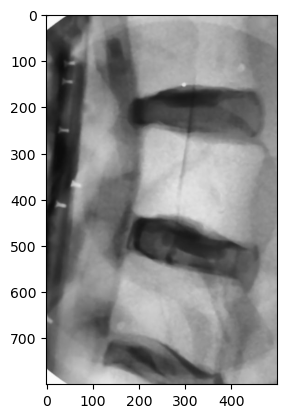

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image, cmap = 'gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img)

plt.figure()
imshow(content_img)

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
def total_variation_loss(image):
    d_h=image[:,:,1:,:]-image[:,:,:-1,:]
    d_w=image[:,:,:,1:]-image[:,:,:,:-1]

    l = torch.sum(torch.abs(d_h))+torch.sum(torch.abs(d_w))

    return l

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.521, 0.521, 0.521])
cnn_normalization_std = torch.tensor([0.193, 0.193, 0.193])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            layer = nn.AvgPool2d(kernel_size = 2, stride = 2)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
            #layer = nn.InstanceNorm2d(3)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

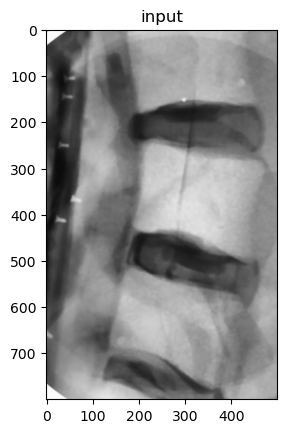

In [ ]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title = "input")

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
sl_history = []
cl_history = []
tl_history = []

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=700,
                       style_weight=1000000, content_weight=10,tv_wgt = 0.0001):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')


    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            tv_loss = total_variation_loss(input_img)

            style_score *= style_weight
            content_score *= content_weight

            sl_history.append(style_score.item())
            cl_history.append(content_score.item())

            loss = style_score + content_score + tv_wgt*tv_loss
            loss.backward()

            tl_history.append(loss.item())

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score + tv_wgt*tv_loss

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [ ]:
%%time

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 8.250838 Content Loss: 5.404761

run [100]:
Style Loss : 1.490367 Content Loss: 3.864573

run [150]:
Style Loss : 1.204057 Content Loss: 3.627815

run [200]:
Style Loss : 1.168535 Content Loss: 3.560541

run [250]:
Style Loss : 1.154610 Content Loss: 3.523395

run [300]:
Style Loss : 1.146447 Content Loss: 3.501151

run [350]:
Style Loss : 1.139215 Content Loss: 3.489279

run [400]:
Style Loss : 1.133287 Content Loss: 3.481852

run [450]:
Style Loss : 1.127792 Content Loss: 3.476901

run [500]:
Style Loss : 1.122213 Content Loss: 3.473659



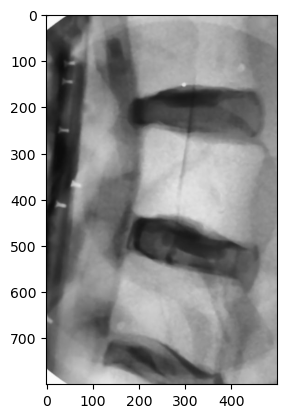

In [ ]:
plt.figure()
imshow(content_img)

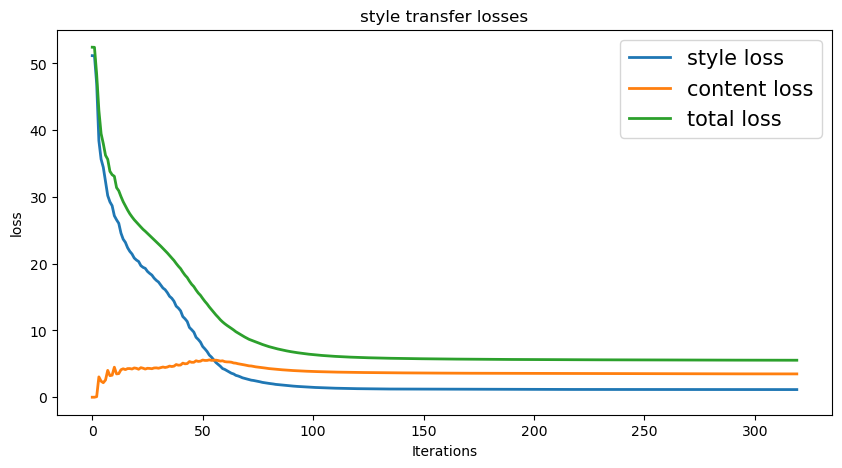

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(sl_history, label="style loss",lw=2)
plt.plot(cl_history, label="content loss",lw=2)
plt.plot(tl_history,label = "total loss",lw=2)
#plt.ylim(top=30,bottom=0)
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.title("style transfer losses")
plt.legend(fontsize = 15)
plt.show()

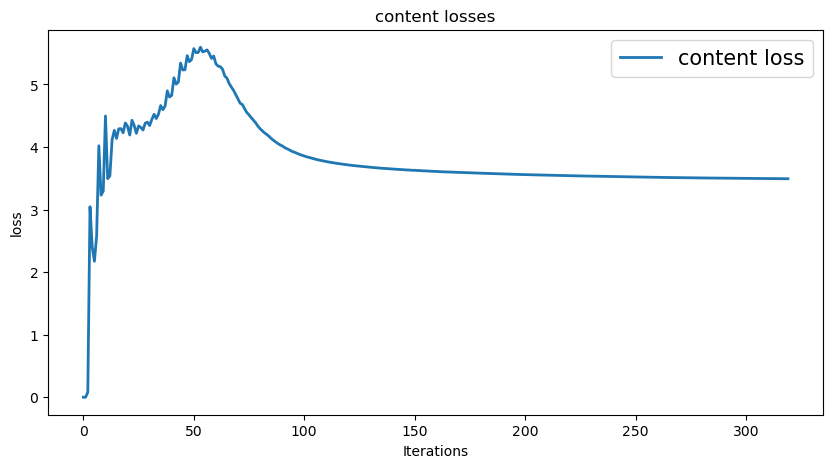

In [ ]:
plt.figure(figsize=(10,5))
#plt.plot(sl_history, label="style loss")
plt.plot(cl_history, label="content loss",lw=2)
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.title("content losses")
plt.legend(fontsize=15)
plt.show()

In [ ]:
op = output[0]

In [ ]:
from torchvision.utils import save_image
save_image(op,"op300.png")

In [ ]:
def ssim(im1,im2):
    mu1 = torch.mean(im1)
    mu2 = torch.mean(im2)
    sigma1 = torch.std(im1)
    sigma2 = torch.std(im2)

    cov = torch.sum((im1 - mu1)*(im2 - mu2))

    ssim = (2* mu1 * mu2 +0.01)/(mu1**2 + mu2**2 + 0.01)
    cs = (2 * sigma1 * sigma2 + 0.01)/(sigma1**2 + sigma2**2 +0.01)

    return ssim * cs

In [ ]:
print(ssim(content_img, output))

tensor(0.9086, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
print(ssim(style_img, output))

tensor(0.9995, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
def psnr(im1,im2):
    max_val = 1
    mse = torch.mean((im1-im2)**2)
    peaksnr = 20*torch.log(max_val/torch.sqrt(mse))
    return peaksnr


In [ ]:
print(psnr(content_img, output))

tensor(34.1315, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
print(psnr(style_img, output))

tensor(39.5189, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
import cv2
import numpy as np

def plot_tone_curves(im1,im2,im3,im4,im5,im6,im7,im8):
    h1 = cv2.calcHist([im1],[0],None,[256],[10,250]).flatten()
    h2 = cv2.calcHist([im2],[0],None,[256],[10,250]).flatten()
    h3 = cv2.calcHist([im3],[0],None,[256],[10,250]).flatten()
    h4 = cv2.calcHist([im4],[0],None,[256],[10,250]).flatten()
    h5 = cv2.calcHist([im5],[0],None,[256],[10,250]).flatten()
    h6 = cv2.calcHist([im6],[0],None,[256],[10,250]).flatten()
    h7 = cv2.calcHist([im7],[0],None,[256],[10,250]).flatten()
    h8 = cv2.calcHist([im8],[0],None,[256],[10,250]).flatten()

    plt.figure(figsize=(24,16))

    plt.subplot(8,1,1)
    plt.plot(h1,color="blue")
    plt.title("X-ray Original")
    plt.xlabel('Pixel Intensity')
    plt.ylabel("Frequency")


    plt.subplot(8,1,2)
    plt.plot(h2,color="red")
    plt.title("DRR Style")
    plt.xlabel('Pixel Intensity')
    plt.ylabel("Frequency")

    plt.subplot(8,1,3)
    plt.plot(h3,color="black")
    plt.title("OP 300")
    plt.xlabel('Pixel Intensity')
    plt.ylabel("Frequency")

    plt.subplot(8,1,4)
    plt.plot(h4,color="black")
    plt.title("OP 500")
    plt.xlabel('Pixel Intensity')
    plt.ylabel("Frequency")

    plt.subplot(8,1,5)
    plt.plot(h5,color="black")
    plt.title("OP 700")
    plt.xlabel('Pixel Intensity')
    plt.ylabel("Frequency")

    plt.subplot(8,1,6)
    plt.plot(h6,color="black")
    plt.title("OP 1000")
    plt.xlabel('Pixel Intensity')
    plt.ylabel("Frequency")

    plt.subplot(8,1,7)
    plt.plot(h7,color="black")
    plt.title("OP 1500")
    plt.xlabel('Pixel Intensity')
    plt.ylabel("Frequency")

    plt.subplot(8,1,8)
    plt.plot(h8,color="black")
    plt.title("OP 2000")
    plt.xlabel('Pixel Intensity')
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

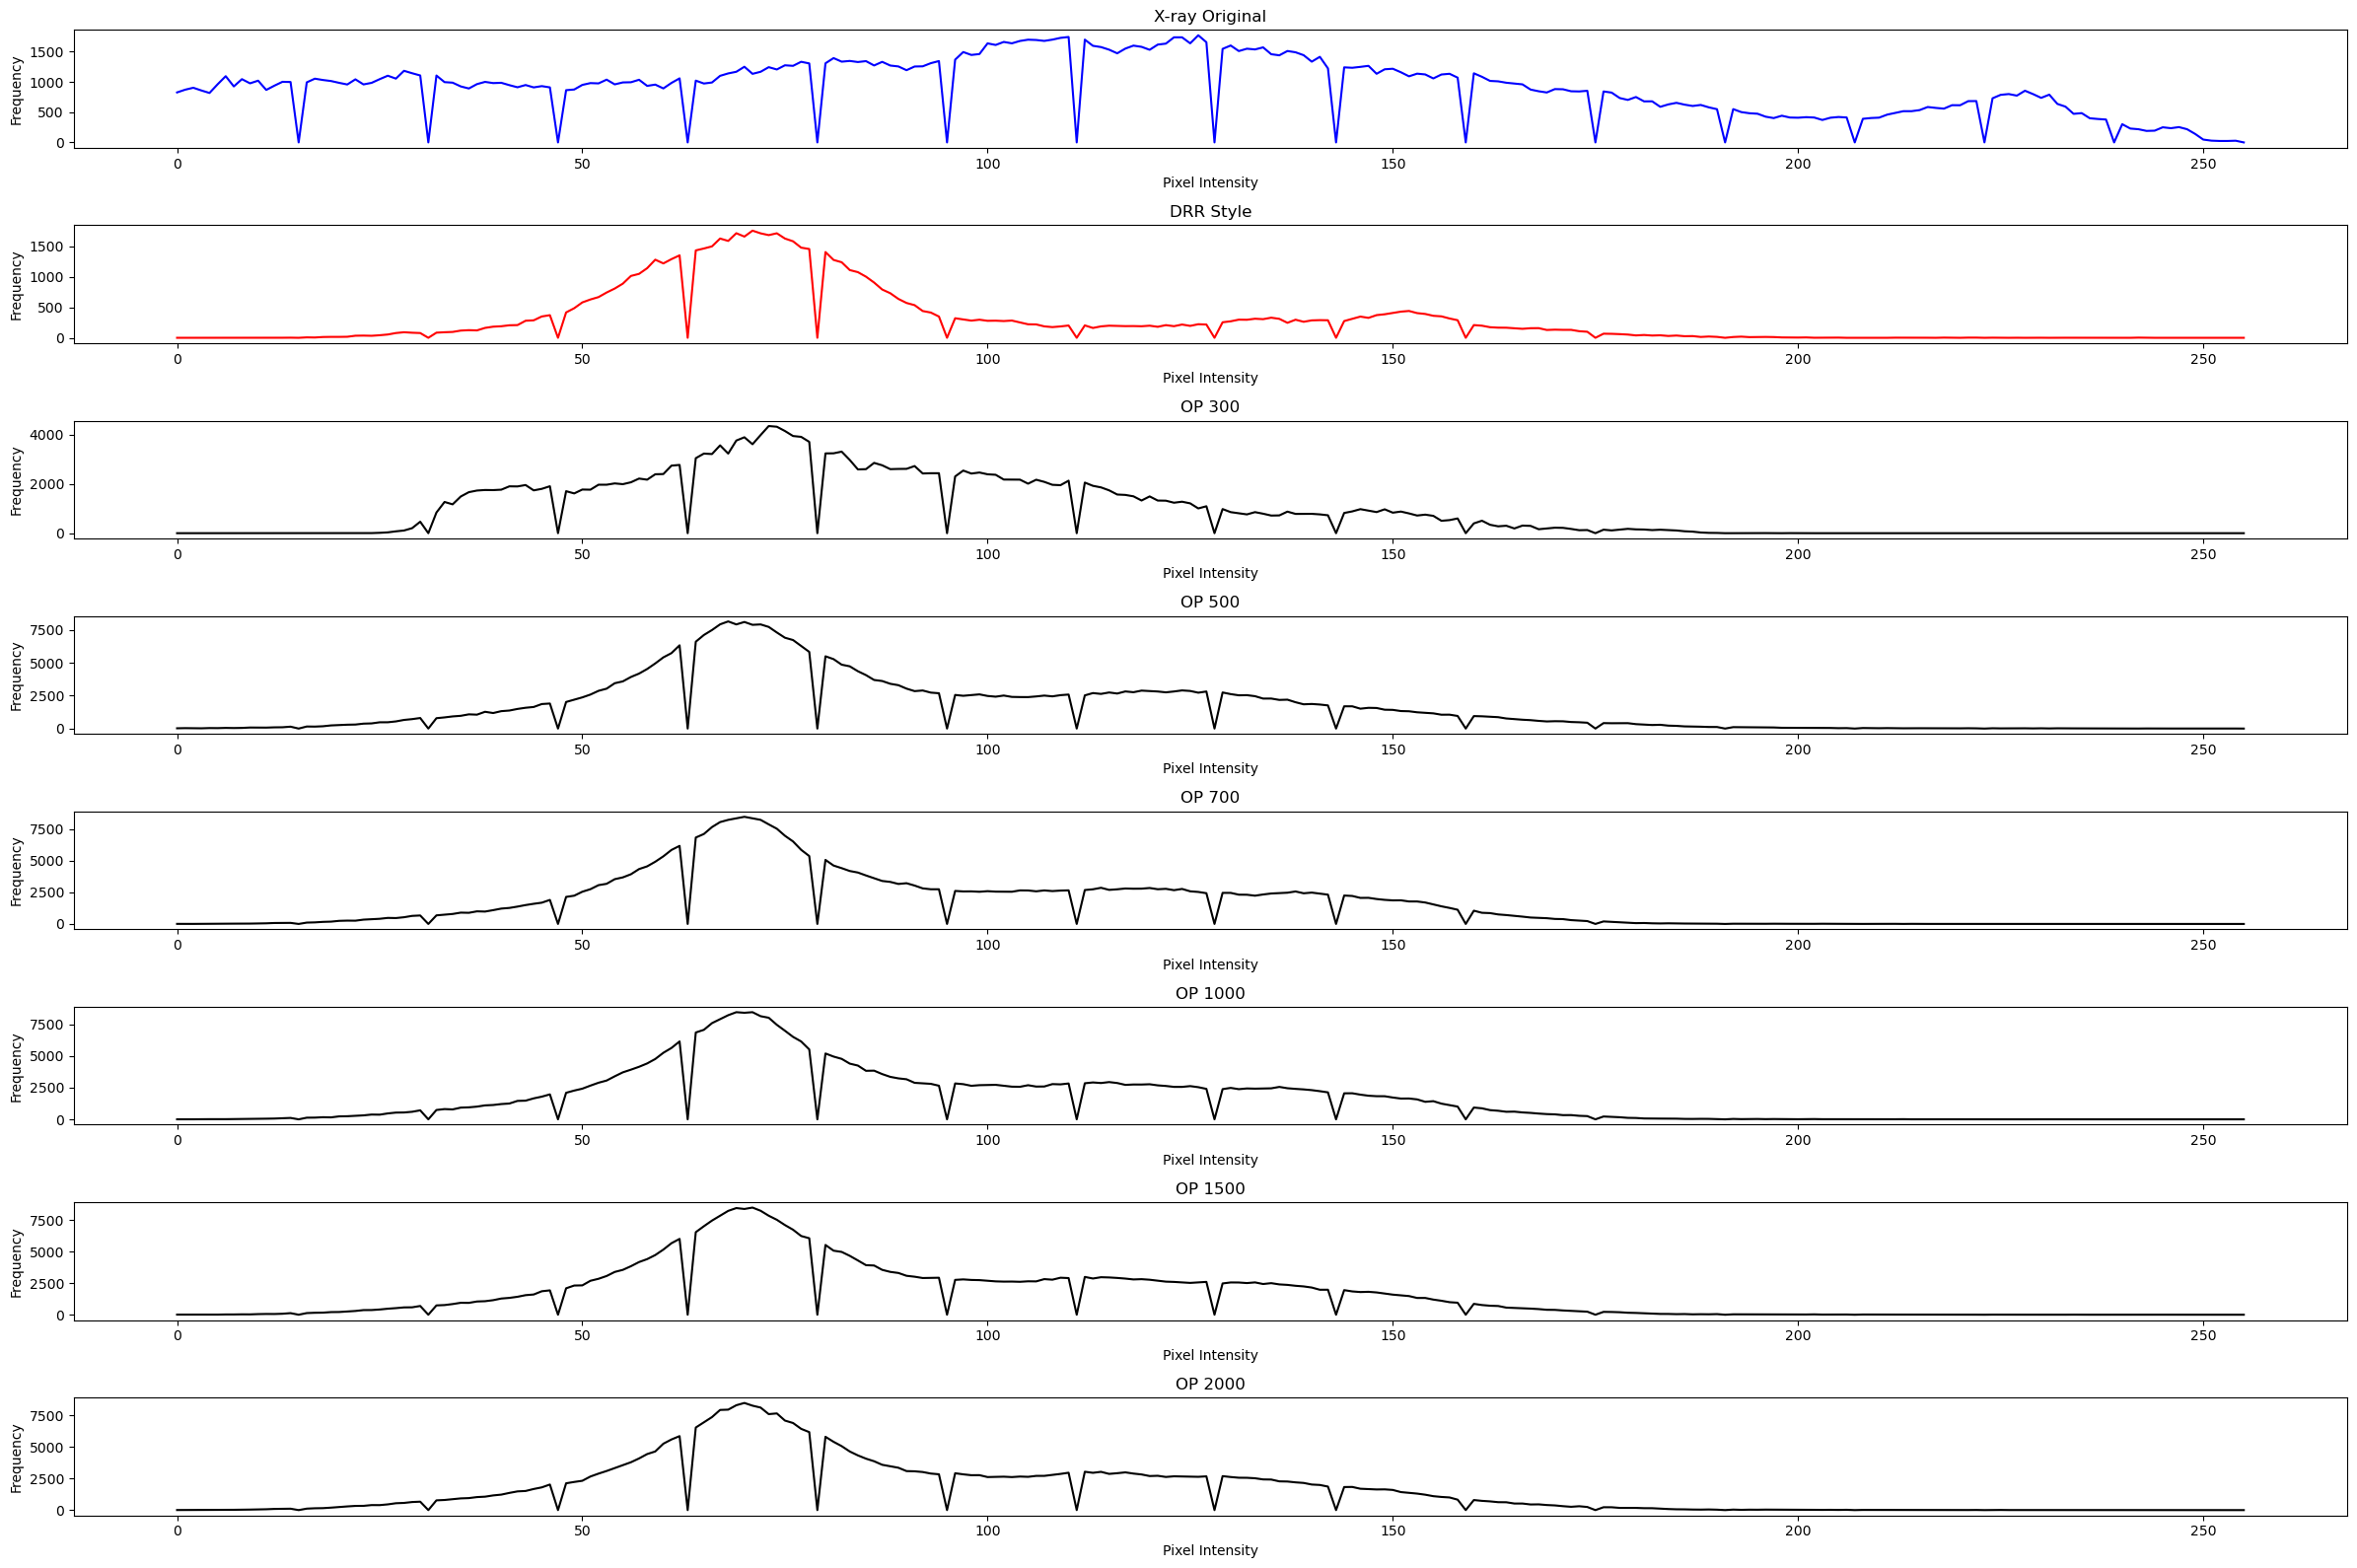

In [ ]:
im1 = cv2.imread("preprocessed_AP.jpg")
im2 = cv2.imread("DRR_AP.jpg")
im3 = cv2.imread("APAP_Avgpool_cwt10/op700_reg.png")
im4 = cv2.imread("LP_AP_AVGPOOL10/op700.png")
im5 = cv2.imread("LP_APs_OP/op700.png")
im6 = cv2.imread("LP_APs_OP/op1000.png")
im7 = cv2.imread("LP_APs_OP/op1500.png")
im8 = cv2.imread("LP_APs_OP/op2000.png")

plot_tone_curves(im1,im2,im3,im4,im5,im6,im7,im8)